# 라이브러리 호출

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import numpy as np
import pandas as pd
import os

# Data summary

전체 데이터 - 불량: 74, 정상: 1378


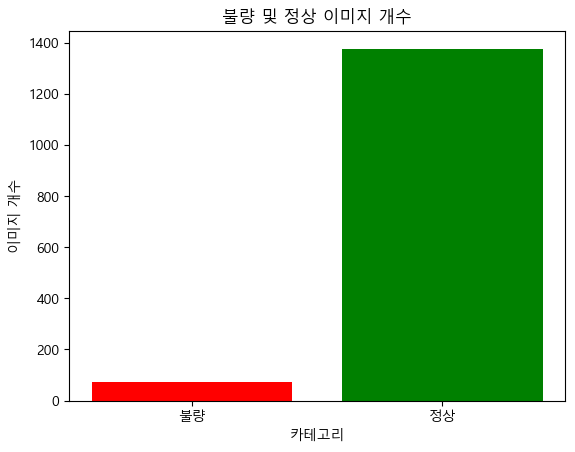

In [3]:
# 디렉토리 경로 설정
base_dir = 'img_data'
defective_dir = os.path.join(base_dir, '불량')
normal_dir = os.path.join(base_dir, '정상')

# 각 디렉토리의 이미지 개수 계산
num_defective = len(os.listdir(defective_dir))
num_normal = len(os.listdir(normal_dir))

# 결과 출력
print(f"전체 데이터 - 불량: {num_defective}, 정상: {num_normal}")

# 시각화
categories = ['불량', '정상']
counts = [num_defective, num_normal]

plt.bar(categories, counts, color=['red', 'green'])
plt.title('불량 및 정상 이미지 개수')
plt.xlabel('카테고리')
plt.ylabel('이미지 개수')
plt.show()


# 데이터 전처리 

In [4]:
# 이미지 전처리 함수 정의 (타겟 사이즈: 258x258, RGB)
def preprocess_images(image_dir, target_size=(258, 258)):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, color_mode='rgb', target_size=target_size)
        img_array = img_to_array(img) / 255.0  # 정규화 (0~1)
        images.append(img_array)
    return np.array(images)

In [5]:
# 데이터 로드
defective_images = preprocess_images(defective_dir)

# 정상 이미지는 랜덤으로 74개 뽑아서 불러오기
all_normal_images = preprocess_images(normal_dir)
random_indices = np.random.choice(len(all_normal_images), num_defective, replace=False)
normal_images = all_normal_images[random_indices]

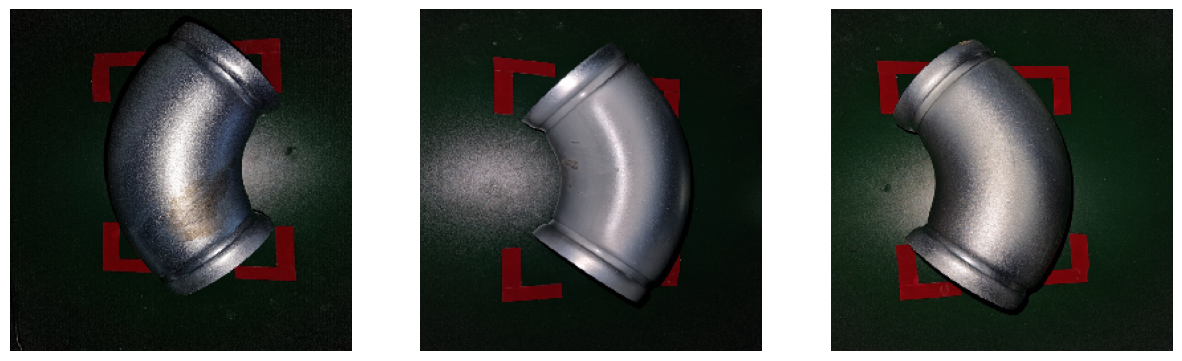

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(defective_images[1])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(defective_images[3])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(normal_images[3])
plt.axis('off')

plt.show()

# 데이터 증강

In [67]:
# 사용자 정의 전처리 함수: 노이즈 추가 및 밝기 조절
def add_noise(image, noise_type="gaussian", mean=0.0, var=0.005):
    """
    이미지에 노이즈를 추가하는 함수.
    
    Args:
        image (np.ndarray): 입력 이미지 (정규화된 [0, 1] 범위).
        noise_type (str): 추가할 노이즈 유형 ("gaussian", "salt_pepper").
        mean (float): Gaussian 노이즈의 평균.
        var (float): Gaussian 노이즈의 분산.
    
    Returns:
        np.ndarray: 노이즈가 추가된 이미지.
    """
    if noise_type == "gaussian":
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, image.shape)
        noisy_image = image + gauss
        noisy_image = np.clip(noisy_image, 0.0, 1.0)  # 픽셀 값을 [0, 1]로 제한
    elif noise_type == "salt_pepper":
        s_vs_p = 0.5
        amount = 0.01  # 노이즈 양을 줄임
        noisy_image = np.copy(image)
        # Salt 노이즈
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 1
        # Pepper 노이즈
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 0
    else:
        raise ValueError("지원하지 않는 노이즈 유형입니다.")
    
    return noisy_image

In [68]:
# 데이터 증강 함수 정의
def augment_images_with_noise(images, augment_count=5):
    """
    이미 불러온 이미지 배열에 노이즈를 추가하고 증강하여 새로운 배열로 반환하는 함수.
    
    Args:
        images (np.ndarray): 입력 이미지 배열 (형태: (N, H, W, C)).
        augment_count (int): 각 이미지당 생성할 증강 이미지 수 (기본값: 5).
    
    Returns:
        np.ndarray: 증강된 이미지 배열.
    """
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',  # fill_mode를 'constant'로 설정
        cval=255  # 흰색으로 채우기 위해 cval을 255로 설정
)
    
    augmented_images = []  # 증강된 이미지를 저장할 리스트
    
    for img in images:
        img_noisy_gaussian = add_noise(img, noise_type="gaussian", mean=0.0, var=0.01)
        img_noisy_salt_pepper = add_noise(img, noise_type="salt_pepper")
        
        # 배치 차원 추가
        img_noisy_gaussian = np.expand_dims(img_noisy_gaussian, axis=0)
        img_noisy_salt_pepper = np.expand_dims(img_noisy_salt_pepper, axis=0)
        
        # Gaussian 노이즈 이미지 증강
        count = 0
        for batch in datagen.flow(img_noisy_gaussian, batch_size=1):
            augmented_images.append(batch[0])
            count += 1
            if count >= augment_count:
                break
        
        # Salt-and-Pepper 노이즈 이미지 증강
        count = 0
        for batch in datagen.flow(img_noisy_salt_pepper, batch_size=1):
            augmented_images.append(batch[0])
            count += 1
            if count >= augment_count:
                break
    
    return np.array(augmented_images)

In [69]:
# 불량 이미지와 정상 이미지에 대해 각각 증강 수행
augment_count = 10

print("불량 이미지 증강 중...")
augmented_defective_images = augment_images_with_noise(defective_images, augment_count)

print("정상 이미지 증강 중...")
augmented_normal_images = augment_images_with_noise(normal_images, augment_count)

# 결과 확인
print(f"증강된 불량 이미지 데이터 형태: {augmented_defective_images.shape}")
print(f"증강된 정상 이미지 데이터 형태: {augmented_normal_images.shape}")

불량 이미지 증강 중...
정상 이미지 증강 중...
증강된 불량 이미지 데이터 형태: (148, 258, 258, 3)
증강된 정상 이미지 데이터 형태: (148, 258, 258, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


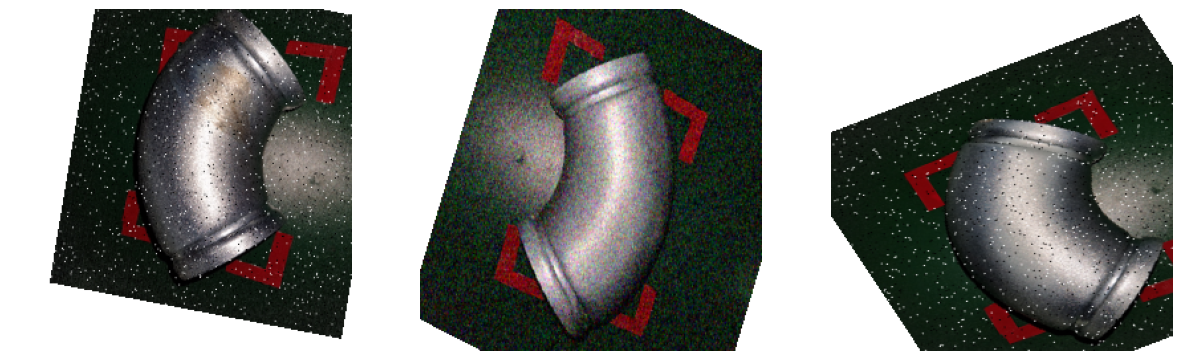

In [73]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(augmented_defective_images[1])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(augmented_defective_images[10])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_normal_images[1])
plt.axis('off')

plt.show()

# 학습 준비

In [47]:
# 라벨 생성 (불량: 0, 정상: 1)
labels_defective = np.zeros(len(augmented_defective_images))
labels_normal = np.ones(len(augmented_normal_images))

In [48]:
combined_images = np.concatenate((augmented_defective_images, augmented_normal_images), axis=0)
combined_labels = np.concatenate((labels_defective, labels_normal), axis=0)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42, stratify=combined_labels
)

In [51]:
# Check the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (4736, 258, 258, 3), Training labels shape: (4736,)
Testing data shape: (1184, 258, 258, 3), Testing labels shape: (1184,)


# 학습

In [52]:
# 모델 정의
input_layer = Input(shape=(258, 258, 3)) 

model = models.Sequential([
    input_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [54]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실(val_loss)을 모니터링
    patience=5,          # 개선되지 않는 에포크가 5번 연속 발생하면 학습 중단
    restore_best_weights=True  # 가장 낮은 검증 손실에서의 가중치를 복원
)

In [56]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # EarlyStopping 콜백 추가
    shuffle=True
)

Epoch 1/20
119/119 [==============================] - 70s 581ms/step - loss: 0.6176 - accuracy: 0.6080 - val_loss: 0.4705 - val_accuracy: 0.7848
Epoch 2/20
119/119 [==============================] - 69s 583ms/step - loss: 0.3815 - accuracy: 0.8157 - val_loss: 0.2881 - val_accuracy: 0.8639
Epoch 3/20
119/119 [==============================] - 73s 614ms/step - loss: 0.2713 - accuracy: 0.8735 - val_loss: 0.2429 - val_accuracy: 0.8924
Epoch 4/20
119/119 [==============================] - 74s 619ms/step - loss: 0.2315 - accuracy: 0.9021 - val_loss: 0.2172 - val_accuracy: 0.9219
Epoch 5/20
119/119 [==============================] - 74s 619ms/step - loss: 0.1472 - accuracy: 0.9406 - val_loss: 0.1635 - val_accuracy: 0.9399
Epoch 6/20
119/119 [==============================] - 76s 642ms/step - loss: 0.0890 - accuracy: 0.9683 - val_loss: 0.1435 - val_accuracy: 0.9420
Epoch 7/20
119/119 [==============================] - 76s 639ms/step - loss: 0.0734 - accuracy: 0.9749 - val_loss: 0.1158 - val_ac

In [57]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

37/37 [==============================] - 5s 132ms/step - loss: 0.2135 - accuracy: 0.9527
Test Loss: 0.2134927213191986
Test Accuracy: 0.9527027010917664


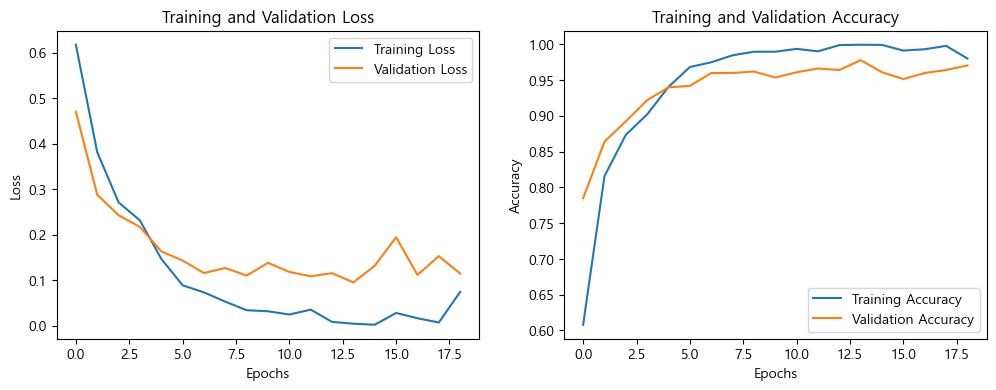

In [58]:
# 학습 성능 그래프
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [59]:
# 모델 저장 (SavedModel 형식)
model.save('models/cnn_model.keras')


In [60]:
# 모델 로드
loaded_model = models.load_model('test_app/models/cnn_model.keras')

# 테스트 데이터 활용 검증

In [61]:
# Combine defective and normal images for testing
combined_test_images = np.concatenate((defective_images, normal_images), axis=0)

# Create labels for the test images (defective: 0, normal: 1)
test_labels_defective = np.zeros(len(defective_images))
test_labels_normal = np.ones(len(normal_images))
combined_test_labels = np.concatenate((test_labels_defective, test_labels_normal), axis=0)

# Evaluate the model on the combined test images
test_loss, test_accuracy = loaded_model.evaluate(combined_test_images, combined_test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 [==============================] - 1s 108ms/step - loss: 0.0644 - accuracy: 0.9865
Test Loss: 0.06443793326616287
Test Accuracy: 0.9864864945411682


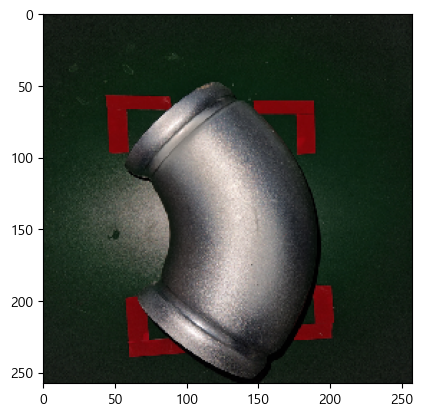

In [62]:
plt.imshow(combined_test_images[80])

In [63]:
# 모델을 사용하여 테스트 데이터에 대한 예측 수행
predictions = loaded_model.predict(combined_test_images)

# 예측 결과를 이진 클래스(0 또는 1)로 변환
predicted_classes = (predictions > 0.5).astype(int).flatten()

# 예측 결과 출력
print("Predicted classes:", predicted_classes)
print("True labels:", combined_test_labels)

5/5 [==============================] - 1s 100ms/step
Predicted classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [64]:
predictions

array([[1.2288157e-15],
       [8.1315204e-32],
       [0.0000000e+00],
       [4.9655722e-28],
       [3.8238414e-04],
       [1.1408489e-06],
       [2.2733332e-07],
       [1.2141892e-30],
       [3.2499271e-34],
       [4.8122347e-33],
       [5.3686232e-32],
       [1.2664568e-19],
       [3.1616660e-32],
       [4.3386349e-30],
       [3.5269095e-37],
       [1.5959834e-32],
       [3.3397207e-01],
       [2.4091229e-01],
       [1.3536097e-06],
       [1.7566874e-05],
       [2.1409240e-04],
       [1.2790639e-03],
       [1.8898272e-09],
       [9.7938884e-09],
       [2.2843095e-10],
       [1.7383773e-22],
       [7.8058548e-02],
       [9.6733500e-05],
       [9.1123569e-04],
       [9.8172385e-01],
       [3.5529860e-29],
       [1.2288157e-15],
       [1.2664568e-19],
       [7.8552622e-38],
       [1.8898272e-09],
       [7.8552622e-38],
       [0.0000000e+00],
       [0.0000000e+00],
       [7.5660986e-38],
       [3.7039842e-32],
       [0.0000000e+00],
       [8.131520